<a href="https://colab.research.google.com/github/Helmi-Y/Wiyah/blob/main/ML_DogBreed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset already extracted.
Dataset contents: ['n02087046-toy_terrier', 'n02106550-Rottweiler', 'n02085782-Japanese_spaniel', 'n02086079-Pekinese', 'n02116738-African_hunting_dog']
Found 20580 images belonging to 120 classes.
Testing filters=32, kernel_size=(3, 3), learning_rate=0.1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


429/429 ━━━━━━━━━━━━━━━━━━━━ 173s 396ms/step - accuracy: 0.0086 - loss: 52.1314 - val_accuracy: 0.0127 - val_loss: 4.8281
429/429 ━━━━━━━━━━━━━━━━━━━━ 159s 362ms/step - accuracy: 0.0085 - loss: 58.5395 - val_accuracy: 0.0090 - val_loss: 4.8248
429/429 ━━━━━━━━━━━━━━━━━━━━ 163s 376ms/step - accuracy: 0.0084 - loss: 119.5549 - val_accuracy: 0.0105 - val_loss: 4.8342
Mean Validation Accuracy: 0.010738580798109373
Best Hyperparameters: Filters=32, Kernel Size=(3, 3), Learning Rate=0.1
644/644 ━━━━━━━━━━━━━━━━━━━━ 285s 439ms/step - accuracy: 0.0098 - loss: 86.0271 - val_accuracy: 0.0090 - val_loss: 4.8135
Final Training Accuracy: 0.009426628239452839
Final Validation Accuracy: 0.008989309892058372


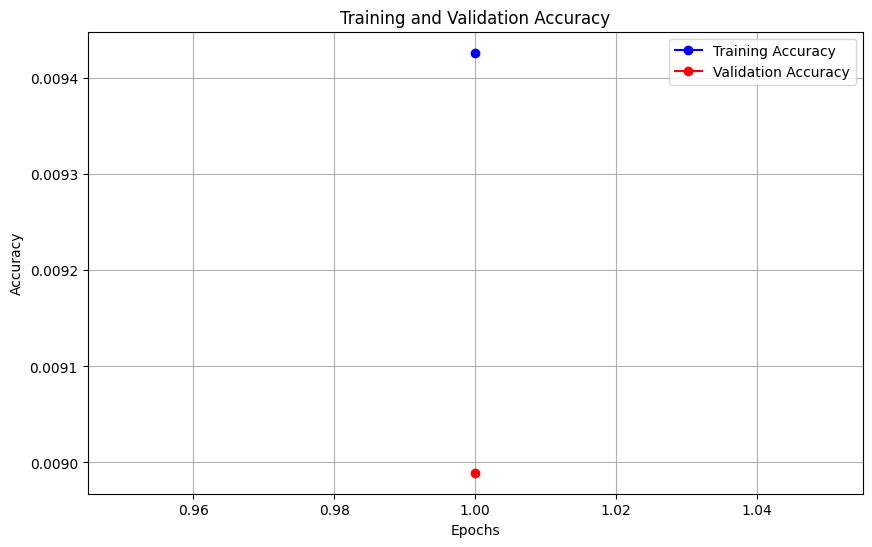

In [ ]:
import os
import urllib.request
import tarfile
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Step 1: Download and Extract Dataset
dataset_url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
download_path = 'dogs_dataset.tar'
extract_path = 'dogs_dataset'

# Download the dataset
if not os.path.exists(download_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, download_path)
    print("Download completed.")

# Extract the dataset
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with tarfile.open(download_path) as tar:
        tar.extractall(path=extract_path)
    print("Extraction completed.")
else:
    print("Dataset already extracted.")

# Step 2: Data Preprocessing
# Define paths
base_dir = os.path.join(extract_path, 'Images')  # Path to the extracted images

# Check directory structure
print(f"Dataset contents: {os.listdir(base_dir)[:5]}")

# Parameters for ImageDataGenerator
img_height, img_width = 64, 64
batch_size = 32

# Create training and validation generators
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,  # 20% of data used for validation
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

# Load all data into memory for k-fold cross-validation
data_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Avoid shuffling for consistent splits
)

X, y = [], []

for i in range(len(data_gen)):
    try:
        batch_X, batch_y = data_gen[i]
        X.append(batch_X)
        y.append(batch_y)
    except Exception as e:
        print(f"Error processing batch {i}: {e}")

X = np.vstack(X)
y = np.vstack(y)

# Step 3: Define Model Builder Function
def build_model(filters=64, kernel_size=(3, 3), learning_rate=0.001):
    model = models.Sequential([
        layers.Conv2D(filters, kernel_size, activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters * 2, kernel_size, activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters * 4, kernel_size, activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(len(data_gen.class_indices), activation='softmax')  # 120 classes
    ])
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# # Step 4: Define Hyperparameter Grid
# filters_list = [32]
# kernel_sizes = [(3, 3)]
# learning_rates = [0.1]

# Step 4: Define Hyperparameter Grid
filters_list = [32, 64]
kernel_sizes = [(3, 3), (5, 5)]
learning_rates = [0.01, 0.1]

# Step 5: k-Fold Cross-Validation and Hyperparameter Tuning
kf = KFold(n_splits=3, shuffle=True, random_state=42)
results = []

for filters in filters_list:
    for kernel_size in kernel_sizes:
        for learning_rate in learning_rates:
            fold_accuracies = []
            print(f"Testing filters={filters}, kernel_size={kernel_size}, learning_rate={learning_rate}")

            for train_idx, val_idx in kf.split(X):
                # Split data into training and validation sets
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                # Generate training and validation batches
                train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
                val_gen = datagen.flow(X_val, y_val, batch_size=batch_size)

                # Build and train the model
                model = build_model(filters, kernel_size, learning_rate)
                history = model.fit(
                    train_gen,
                    validation_data=val_gen,
                    epochs=1,  # Adjust the number of epochs
                    verbose=1
                )

              #  # Check the history keys for validation accuracy
              #   print("History keys:", history.history.keys())

                # Store validation accuracy from the last epoch, handling missing keys
                fold_accuracies.append(history.history.get('val_accuracy', history.history.get('val_acc', None))[-1])

            # Calculate mean accuracy across folds
            mean_accuracy = np.mean(fold_accuracies)
            results.append((filters, kernel_size, learning_rate, mean_accuracy))
            print(f"Mean Validation Accuracy: {mean_accuracy}")

# Step 6: Select Best Hyperparameters
best_hyperparameters = max(results, key=lambda x: x[3])  # Select combination with highest accuracy
print(f"Best Hyperparameters: Filters={best_hyperparameters[0]}, Kernel Size={best_hyperparameters[1]}, Learning Rate={best_hyperparameters[2]}")

# Step 7: Train Final Model with Best Hyperparameters
best_filters, best_kernel_size, best_learning_rate = best_hyperparameters[:3]
final_model = build_model(filters=best_filters, kernel_size=best_kernel_size, learning_rate=best_learning_rate)

# Train final model on entire training set
final_history = final_model.fit(
    datagen.flow(X, y, batch_size=batch_size),
    validation_data=datagen.flow(X, y, batch_size=batch_size),
    epochs=1,  # Adjust as needed
    verbose=1
)

# Extract accuracy and validation accuracy from training history
final_train_acc = final_history.history['accuracy']
final_val_acc = final_history.history['val_accuracy']
epochs = range(1, len(final_train_acc) + 1)
print(f"Final Training Accuracy: {final_train_acc[-1]}")
print(f"Final Validation Accuracy: {final_val_acc[-1]}")

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, final_train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, final_val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


Download completed.
Extracting dataset...
Extraction completed.
Found 20580 images belonging to 120 classes.
Accuracy: 0.00413022351797862


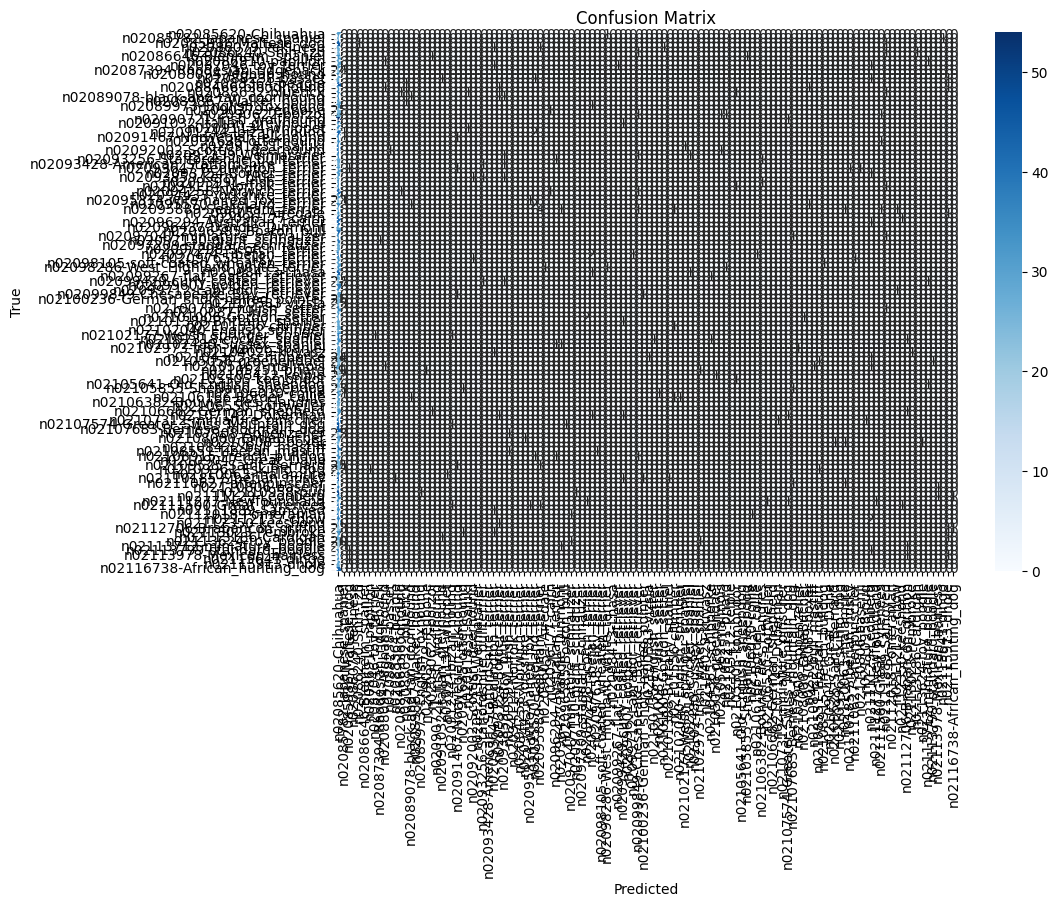

In [ ]:
import os
import urllib.request
import tarfile
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Step 1: Download and Extract Dataset
dataset_url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
download_path = 'dogs_dataset.tar'
extract_path = 'dogs_dataset'

# Download the dataset
if not os.path.exists(download_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, download_path)
    print("Download completed.")

# Extract the dataset
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with tarfile.open(download_path) as tar:
        tar.extractall(path=extract_path)
    print("Extraction completed.")
else:
    print("Dataset already extracted.")

# Step 2: Data Preprocessing
# Define paths
base_dir = os.path.join(extract_path, 'Images')  # Path to the extracted images

# Parameters for ImageDataGenerator
img_height, img_width = 64, 64
batch_size = 32

# Create training and validation generators
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,  # 20% of data used for validation
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

# Load all data into memory for k-fold cross-validation
data_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Avoid shuffling for consistent splits
)

X, y = [], []

# Collect the data into arrays
for i in range(len(data_gen)):
    try:
        batch_X, batch_y = data_gen[i]
        X.append(batch_X)
        y.append(batch_y)
    except Exception as e:
        print(f"Error processing batch {i}: {e}")

X = np.vstack(X)
y = np.vstack(y)

# Step 3: Preprocess the data for kNN
# Flatten the images (each image becomes a vector)
X_flat = X.reshape(X.shape[0], -1)

# Optionally, apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_flat)

# Standardize the features (important for kNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)  # Standardize using PCA-transformed data

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Train the kNN model
k = 3  # You can experiment with different values of k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Step 6: Evaluate the kNN model
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Step 7: Plot the confusion matrix (optional, useful for classification tasks)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_gen.class_indices.keys(), yticklabels=data_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


